In [ ]:
import networkx as nx
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install biopython # Install the Biopython library
from Bio import Entrez
import time
import numpy as np


In [ ]:
file_path = '/content/PathLinker_2018_human-ppi-weighted-cap0_75.txt'

In [ ]:
with open(file_path, 'r') as file_in:
    print("Single Line:", file_in.readline())  # Read one line


Single Line: #tail	head	edge_weight	edge_type



In [ ]:
# Parsing tab-delimited data into a dictionary

interactome = {}

with open(file_path, 'r') as file_in:
    for line in file_in:
        if line.startswith('#') or not line.strip():
            continue  # Skip headers and empty lines

        line_items = line.strip().split('\t')

        # Ensure the line has the expected number of columns
        if len(line_items) < 3:
            print(f"Skipping malformed line: {line.strip()}")
            continue

        try:
            tail, head, edge_weight = line_items[0], line_items[1], float(line_items[2])
            interactome[(tail, head)] = edge_weight
        except ValueError as e:
            print(f"Skipping line due to error: {e} | Line: {line.strip()}")

print("Parsed Data:", interactome)


Skipping malformed line: P28482	P34925
Parsed Data: {('Q8TBF5', 'Q9UKB1'): 0.311133, ('Q8TBF4', 'Q15717'): 0.311133, ('Q8TBF4', 'P08865'): 0.311133, ('Q8TBF4', 'Q02539'): 0.311133, ('Q8TBF4', 'Q96J01'): 0.201461, ('Q8TBF4', 'P51148'): 0.710749, ('Q8TBF4', 'Q8NI27'): 0.201461, ('Q8TBF4', 'Q15696'): 0.311133, ('Q8TBF4', 'O43660'): 0.201461, ('Q8TBF4', 'Q15527'): 0.311133, ('Q8TBF4', 'P15880'): 0.311133, ('Q8TBF4', 'Q9UGY1'): 0.311133, ('Q8TBF4', 'Q96HE9'): 0.311133, ('Q8TBF4', 'Q6I9Y2'): 0.201461, ('Q8TBF4', 'Q8N5P1'): 0.311133, ('Q5MIZ7', 'Q8N490'): 0.311133, ('Q5MIZ7', 'Q53ET0'): 0.493089, ('Q5MIZ7', 'P51648'): 0.311133, ('Q5MIZ7', 'P04629'): 0.311133, ('Q5MIZ7', 'P46379'): 0.311133, ('Q5MIZ7', 'P16104'): 0.75, ('Q5MIZ7', 'Q99689'): 0.75, ('Q5MIZ7', 'P62714'): 0.311133, ('Q5MIZ7', 'Q9H3S7'): 0.201461, ('Q5MIZ7', 'Q16719'): 0.201461, ('Q5MIZ7', 'Q86VU5'): 0.311133, ('Q5MIZ7', 'Q96LJ8'): 0.311133, ('Q5MIZ7', 'Q07866'): 0.201461, ('Q5MIZ7', 'P27348'): 0.201461, ('Q5MIZ7', 'Q9NR45'): 0.201

In [ ]:
import os
print("File exists:", os.path.isfile('/content/PathLinker_PPI_modified.txt'))

File exists: True


In [ ]:
import networkx as nx

# Create a directed graph
biologica_network = nx.DiGraph()

# Add edges to the graph from the parsed dictionary
for (tail, head), weight in interactome.items():
    biologica_network.add_edge(tail, head, weight=weight)

# Print basic graph information
print("Number of nodes:", biologica_network.number_of_nodes())
print("Number of edges:", biologica_network.number_of_edges())

Number of nodes: 9245
Number of edges: 27493


In [ ]:
seed_protein = "Q5MIZ7"  # Replace with actual UniProt ID

# Get first-degree neighbors (direct interactions)
pathway_nodes = set(biologica_network.successors(seed_protein)) | set(biologica_network.predecessors(seed_protein))
pathway_nodes.add(seed_protein)

# Extract the subgraph
seed_method_pathway = biologica_network.subgraph(pathway_nodes)

print(f"Pathway Graph - Nodes: {seed_method_pathway.number_of_nodes()}, Edges: {seed_method_pathway.number_of_edges()}")


Pathway Graph - Nodes: 34, Edges: 33


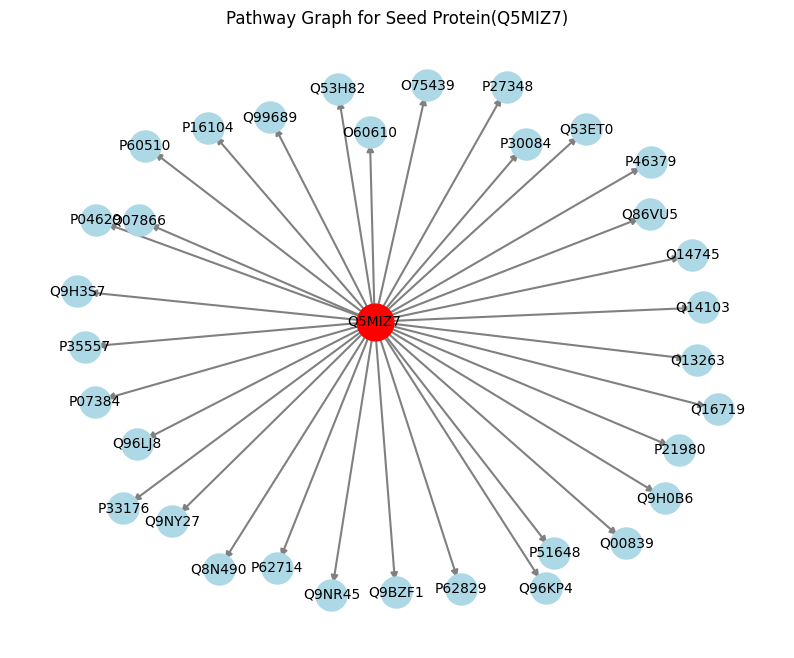

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))  # Set the figure size

# Use a spring layout for better visualization
pos = nx.spring_layout(seed_method_pathway, seed=34)  # Seed for reproducibility

# Draw nodes and edges
nx.draw_networkx_nodes(seed_method_pathway, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(seed_method_pathway, pos, edge_color="gray", width=1.5)

# Draw labels
nx.draw_networkx_labels(seed_method_pathway, pos, font_size=10, font_color="black")

# Highlight the seed protein
nx.draw_networkx_nodes(seed_method_pathway, pos, nodelist=[seed_protein], node_size=700, node_color="red")

# Add a title
plt.title(f"Pathway Graph for Seed Protein(Q5MIZ7)")

# Remove axes for a cleaner look
plt.axis("off")

plt.savefig(f"Pathway Graph for Seed Protein: {seed_protein}.png")

# Show the plot
plt.show()


In [ ]:
import networkx as nx

# Define your source protein
source = "Q5MIZ7"

# Compute shortest path lengths from source to all other nodes
lengths = nx.single_source_dijkstra_path_length(seed_method_pathway, source, weight="weight")

# Pick the most distant protein
target = max(lengths, key=lengths.get)  # Protein with the longest shortest path

print(f"Selected Source: {source}")
print(f"Selected Target: {target}")


Selected Source: Q5MIZ7
Selected Target: P16104


In [ ]:

target = "P16104"  # Your selected target protein

if target in seed_method_pathway.nodes:
    print(f"✅ Target protein {target} is present in the graph.")
else:
    print(f"❌ Target protein {target} is NOT in the graph.")


✅ Target protein P16104 is present in the graph.


Results saved to shortest_paths.txt


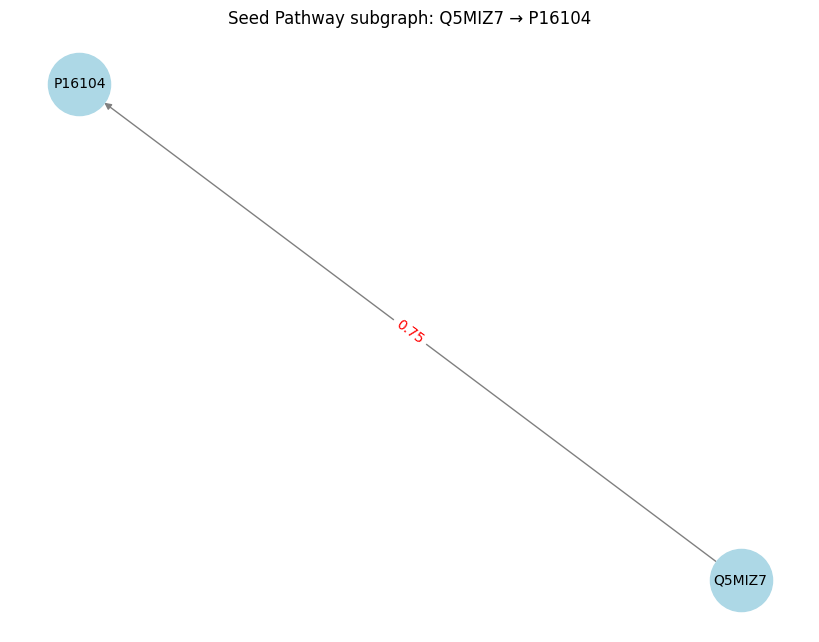

In [ ]:
def find_acyclic_shortest_paths(seed_pathway_graph, source, target, output_file="shortest_paths.txt"):

    weighted_paths = sorted(
        [(f"Path {idx + 1}", path, [seed_method_pathway[u][v]['weight'] for u, v in zip(path, path[1:])])
         for idx, path in enumerate(paths)],
        key=lambda x: sum(x[2])
    )
    with open(output_file, "w") as f:
        f.write(f"Paths between {source} and {target} in the Seed Pathway Graph:\n\n")
        for name, path, weights in weighted_paths:
            f.write(f"{name}: {' -> '.join(path)}\nWeights: {weights}\nTotal Score: {sum(weights)}\n\n")

    print(f"Results saved to {output_file}")

    draw_subgraph(seed_method_pathway, weighted_paths, source, target)

def draw_subgraph(seed_pathway_graph, weighted_paths, source, target):
    subgraph_nodes = {node for _, path, _ in weighted_paths for node in path}
    subgraph = seed_method_pathway.subgraph(subgraph_nodes)
    pos = nx.spring_layout(subgraph)

    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(subgraph, pos,
                                 {(u, v): round(seed_method_pathway[u][v]['weight'], 2) for u, v in
                                  subgraph.edges()}, font_color='red')

    plt.title(f"Seed Pathway subgraph: {source} → {target}") # Indentation fixed here
    plt.show() # Indentation fixed here
find_acyclic_shortest_paths(seed_method_pathway, source, target)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

paths = list(nx.all_simple_paths(seed_method_pathway, source, target, cutoff=5))  # Limit to paths ≤ 5 edges

if nx.has_path(seed_method_pathway, source, target):
    print(f"There is a path between {source} and {target}.")
else:
    print(f"No path exists between {source} and {target}.")



There is a path between Q5MIZ7 and P16104.


In [ ]:
import networkx as nx

def list_direct_connections(seed_pathway_graph, protein, output_file="direct_connections.txt"):
    """Lists all directly connected proteins to a given protein, reports its degree, and saves the result."""

    if protein not in seed_method_pathway:
        print(f"Error: {protein} not found in the Seed Pathway Graph.")
        return

    # Get directly connected proteins (neighbors)
    neighbors = list(seed_method_pathway.neighbors(protein))
    degree = seed_pathway_graph.degree(protein)

    # Save results to a text file
    with open(output_file, "w") as f:
        f.write(f"Protein: {protein}\n")
        f.write(f"Degree (Number of Connections): {degree}\n\n")
        f.write("Connected Proteins:\n")
        for neighbor in neighbors:
            weight = seed_method_pathway[protein][neighbor]['weight']
            f.write(f"{neighbor} (Weight: {weight})\n")

    print(f"Results saved to {output_file}")

# Example usage:
list_direct_connections(seed_method_pathway, "Q5MIZ7")


Results saved to direct_connections.txt


In [ ]:
import random
protein_list = random.sample(list(biologica_network.nodes), 50)  # Select 50 random proteins
# Save the list to a file
with open("random_proteins.txt", "w") as f:
    for protein in protein_list:
        f.write(protein + "\n")
print("Randomly selected proteins saved to random_proteins.txt") # Added closing parenthesis

Randomly selected proteins saved to random_proteins.txt


Protein ranking saved to protein_degree_ranking.txt


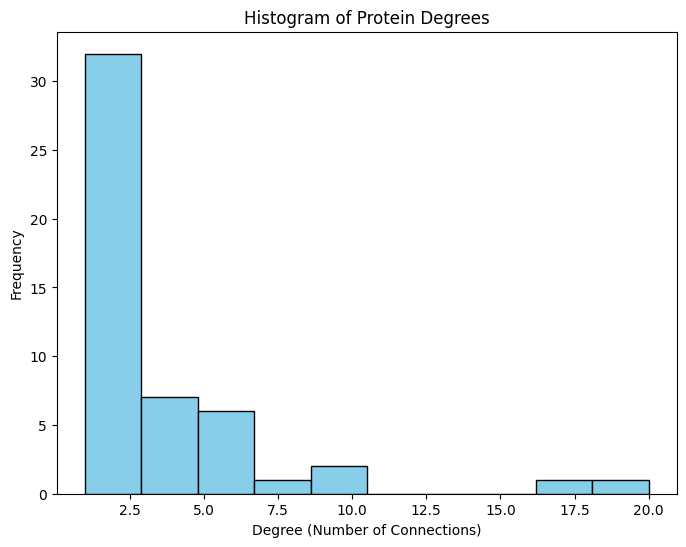

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the random proteins from the file
with open("random_proteins.txt", "r") as f:
    protein_list = [line.strip() for line in f]

# Create a graph from the biological network (assuming you already have it)
# If not, you need to construct the graph from the (tail, head, weight) dictionary
G = nx.DiGraph()
for (tail, head), weight in interactome.items():
    G.add_edge(tail, head, weight=weight)

# Compute degrees of selected proteins
protein_degrees = {p: G.degree(p) for p in protein_list if p in G}

# Sort proteins by degree (high to low)
sorted_proteins = sorted(protein_degrees.items(), key=lambda x: x[1], reverse=True)

# Save ranking to a text file
with open("protein_degree_ranking.txt", "w") as f:
    f.write("Protein Degree Ranking (Highly Connected to Least Connected):\n\n")
    for protein, degree in sorted_proteins:
        f.write(f"{protein}: {degree}\n")

print("Protein ranking saved to protein_degree_ranking.txt")

# Draw histogram
plt.figure(figsize=(8, 6))
plt.hist(protein_degrees.values(), bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency")
plt.title("Histogram of Protein Degrees")
plt.show()


In [ ]:


!pip install biopython # Install the Biopython library
from Bio import Entrez
import time

# Set your email (required for NCBI Entrez)
Entrez.email = "safaelzhar@gmail.com"

def fetch_gene_names(protein_ids, batch_size=100):
    """Fetch gene names for a list of UniProt IDs using NCBI Entrez in batches."""
    gene_map = {}

    for i in range(0, len(protein_ids), batch_size):
        batch = protein_ids[i:i + batch_size]  # Process in batches
        query = " OR ".join(batch)

        try:
            handle = Entrez.esearch(db="protein", term=query, retmax=batch_size)
            record = Entrez.read(handle)
            handle.close()

            if not record["IdList"]:  # Skip if no results
                continue

            handle = Entrez.efetch(db="protein", id=",".join(record["IdList"]), rettype="gb", retmode="text")
            data = handle.read().split("\n\n")
            handle.close()

            for entry in data:
                uniprot_id, gene_name = None, "Unknown"
                for line in entry.split("\n"):
                    if "VERSION" in line:
                        uniprot_id = line.split()[1]
                    if "/gene=" in line:
                        gene_name = line.split("=")[1].strip().replace('"', '')

                if uniprot_id:
                    gene_map[uniprot_id] = gene_name

        except Exception as e:
            print(f"Error fetching batch: {e}")

        time.sleep(1)  # Prevents API rate limits

    return gene_map

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.7 MB/s eta 0:00:00


In [ ]:
import networkx as nx
import numpy as np

def save_unweighted_adj_matrix(seed_method_pathway, output_file="adjacency_matrix.txt"):
    """Convert a weighted graph to unweighted and save its adjacency matrix."""

    # Convert to unweighted graph
    unweighted_graph = nx.Graph(seed_method_pathway.edges())

    # Get nodes list for indexing
    nodes = list(unweighted_graph.nodes)

    # Create adjacency matrix manually using a loop
    matrix = np.zeros((len(nodes), len(nodes)), dtype=int)

    for i, node1 in enumerate(nodes):
        for j, node2 in enumerate(nodes):
            if unweighted_graph.has_edge(node1, node2):
                matrix[i, j] = 1

    # Save to file
    np.savetxt(output_file, matrix, fmt="%d")

    print(f"Adjacency matrix saved to {output_file}")

# Example call
save_unweighted_adj_matrix(seed_method_pathway)


Adjacency matrix saved to adjacency_matrix.txt


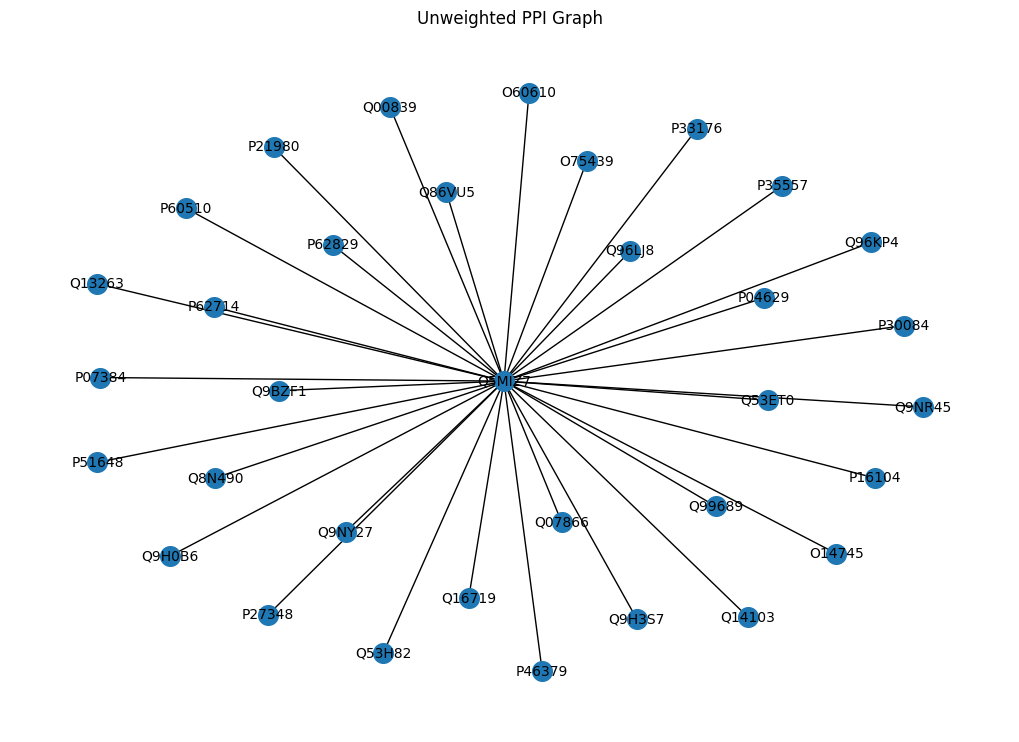

In [ ]:



import pandas as pd # Import pandas



# 1. Get the edges and weights as a list of tuples
edges_data = [(u, v, seed_method_pathway[u][v]['weight']) for u, v in seed_method_pathway.edges()]

# 2. Create a Pandas DataFrame from the edge data
df = pd.DataFrame(edges_data, columns=['Tail', 'Head', 'weight'])

# 3. Now use from_pandas_edgelist with the DataFrame
unweighted_graph = nx.from_pandas_edgelist(df, source='Tail', target='Head', create_using=nx.Graph)

# Plot Unweighted Graph
plt.figure(figsize=(10, 7))
nx.draw(unweighted_graph, with_labels=True, node_size=200, font_size=10)
plt.title("Unweighted PPI Graph")
plt.show()

In [ ]:

protein_names = list(unweighted_graph.nodes)


adjacency_mat = nx.to_numpy_array(unweighted_graph, dtype=int)
adjacency_df = pd.DataFrame(adjacency_mat, index=protein_names, columns=protein_names)
# Save to CSV

adjacency_df.to_csv("/content/adjacency_matrix.csv")



In [ ]:
def analyze_protein_degrees(biologica_network, random_proteins_txt, output_file="protein_degree_ranking.txt"):
    """Analyzes the degree of proteins and saves ranking + histogram."""

    # Get degree of each protein
    with open(random_proteins_txt, 'r') as f:  # Open the file for reading
        random_proteins = [line.strip()
         for line in f]

    protein_degrees = {p: biologica_network.degree(p) for p in random_proteins if p in biologica_network}  # Use degree method

    if not protein_degrees:
        print("Error: None of the selected proteins were found in the Seed Pathway Graph.")
        return

In [ ]:
import requests

def get_kegg_pathway_proteins(pathway_id):
    """
    Fetch all proteins (KEGG gene IDs) in a KEGG pathway.
    Example pathway_id: "hsa04010" (MAPK pathway in humans)
    """
    url = f"https://rest.kegg.jp/link/uniprot/{pathway_id}"
    response = requests.get(url)

    if response.status_code == 200:
        proteins = {line.split("\t")[1] for line in response.text.strip().split("\n")}
        return proteins
    else:
        print("Error fetching KEGG pathway.")
        return set()

# Example: Fetch proteins for the KEGG MAPK pathway
kegg_pathway_proteins = get_kegg_pathway_proteins("hsa04010")
print(f"Retrieved {len(kegg_pathway_proteins)} proteins from KEGG pathway.")


Error fetching KEGG pathway.
Retrieved 0 proteins from KEGG pathway.


In [ ]:
with open("/content/random_proteins.txt") as f:
    protein_list = [line.strip() for line in f]  # Read from file

# Fetch and save results
gene_mapping = fetch_gene_names(protein_list)

with open("protein_gene_mapping.txt", "w") as f:
    for uniprot, gene in gene_mapping.items():
        f.write(f"{uniprot}: {gene}\n")

print("Gene mapping saved to 'protein_gene_mapping.txt'.")


Gene mapping saved to 'protein_gene_mapping.txt'.


In [ ]:
from Bio import Entrez

# Set your email (required for NCBI Entrez)
Entrez.email = "your_email@example.com"

def fetch_gene_name(uniprot_id):
    """Fetch the gene name for a single UniProt ID using NCBI Entrez."""
    try:
        handle = Entrez.esearch(db="protein", term=uniprot_id, retmax=1)
        record = Entrez.read(handle)
        handle.close()

        if not record["IdList"]:
            return f"No gene found for {uniprot_id}"

        handle = Entrez.efetch(db="protein", id=record["IdList"][0], rettype="gb", retmode="text")
        data = handle.read()
        handle.close()

        for line in data.split("\n"):
            if "/gene=" in line:
                gene_name = line.split("=")[1].strip().replace('"', '')  # ✅ Fixed the syntax issue
                return f"{uniprot_id}: {gene_name}"

    except Exception as e:
        return f"Error: {e}"

    return f"No gene found for {uniprot_id}"

# 🔹 **Replace with your UniProt ID**
uniprot_id = "Q9Y2H5"  # Example UniProt ID

# Fetch and print the result
print(fetch_gene_name(uniprot_id))


Q9Y2H5: PLEKHA6


In [ ]:
import networkx as nx
selected_method = "KEGG activation"  # Replace with actual method

# Assuming 'interactome' holds the interaction data:
interactions = interactome  # Assign interactome to interactions

# Create a placeholder for methods_dict (you'll need to populate this)
# For this example, we'll assume all interactions are 'biochemical'
methods_dict = {(tail, head): "KEGG activation" for (tail, head) in interactions}

# Filter interactions by method
filtered_edges = {
    (tail, head): weight
    for (tail, head), weight in interactions.items()
    if methods_dict[(tail, head)] == selected_method
}

# Construct a new graph with only the selected pathway
biologica_network = nx.DiGraph()
# Correct the variable name from 'M_pathway_pathway' to 'M_pathway'
for (tail, head), weight in filtered_edges.items():
    biologica_network.add_edge(tail, head, weight=weight)

print(f"Pathway Graph - Nodes: {biologica_network.number_of_nodes()}, Edges: {biologica_network.number_of_edges()}")

Pathway Graph - Nodes: 17168, Edges: 612516


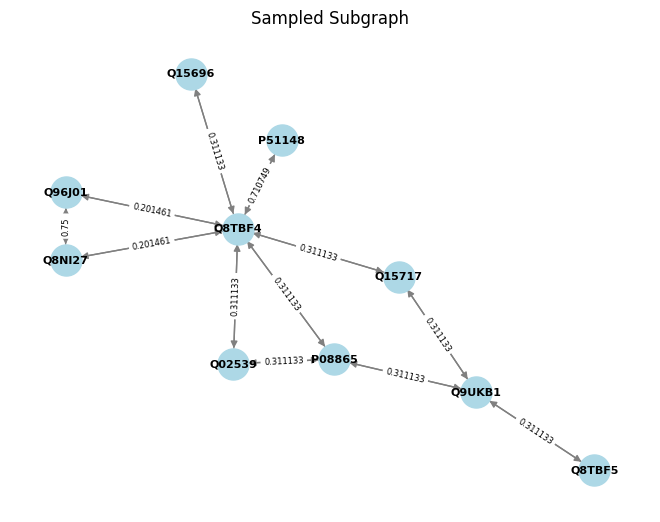

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt # Import the necessary module



# Sample 10 nodes from the graph
sampled_nodes = list(biologica_network.nodes())[:10]  # Change M_pathway() to M_pathway.nodes()
sampled_subgraph = biologica_network.subgraph(sampled_nodes)

# Visualize the sampled subgraph
pos = nx.spring_layout(sampled_subgraph)
nx.draw(sampled_subgraph, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=8, font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(sampled_subgraph, "weight")
nx.draw_networkx_edge_labels(sampled_subgraph, pos, edge_labels=edge_labels, font_size=6)

plt.title("Sampled Subgraph") # Now plt is defined and can be used
plt.savefig("sampled_subgraph.png")
plt.show()

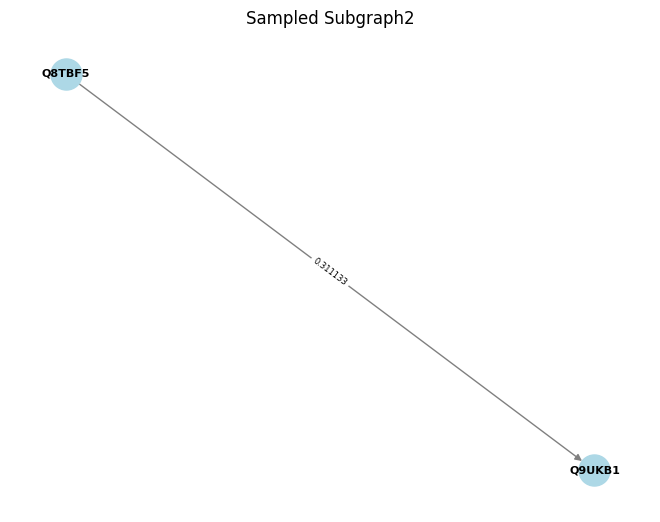

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt # Import the necessary module

# ... (rest of your code) ...

# Sample nodes from the graph
sampled_nodes2 = list(G_pathway.nodes())  # Change G_pathway() to G_pathway.nodes()
sampled_subgraph2 = G.subgraph(sampled_nodes2)

# Visualize the sampled subgraph
pos = nx.spring_layout(sampled_subgraph2)
nx.draw(sampled_subgraph2, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=8, font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(sampled_subgraph2, "weight")
nx.draw_networkx_edge_labels(sampled_subgraph2, pos, edge_labels=edge_labels, font_size=6)

plt.title("Sampled Subgraph2") # Now plt is defined and can be used
plt.savefig("sampled_subgraph2.png")
plt.show()